# How to generate a tree from single photons

In this some tutorial we well see how to use single photons and the [perceval](https://perceval.quandela.net/) simulation software to plot a Christmas tree.

This is based on the idea that single-photons act as qubit and that by applying some gates. we can tweak the probability of observing photons in different positions at the end of a circuit. Plotting this spatial probability allows to plot drawings.

First let's import and configure the packages


In [1]:
import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
from perceval.components.unitary_components import BS, PERM
from perceval.rendering.circuit import DisplayConfig, SymbSkin

DisplayConfig.select_skin(SymbSkin)

## One-mode circuit

Let's generate a circuit with a single spatial mode, i.e. only one possible position for the photon. We will here consider lossless interactions so we don't loose photons.

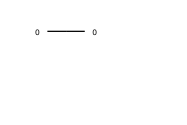

In [7]:
circuit_one_mode = pcvl.Circuit(1)

pcvl.pdisplay(circuit_one_mode)

Now let's input some photons at the spatial mode 0 and see where we observe the photons at the output. For that we will send 1000 single photons and look where our detectors click at the end.


In [8]:
p = pcvl.Processor("SLOS", circuit_one_mode)
p.with_input(pcvl.BasicState([1]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
print(sample_count["results"])

{
  |1>: 1000
}


As expected all our photons are found in the only possible spatial mode. Now let's go to 2-mode circuits.


## 2-mode circuits

Let's now take a 2-mode circuit. We will still only input photon, but we can now use some kind of optical components that will act as qubits to have more interesting behaviors.

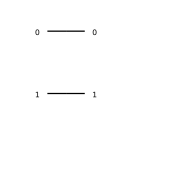

In [13]:
circuit_two_modes = pcvl.Circuit(2)

pcvl.pdisplay(circuit_two_modes)

Just taking the default circuit and if I input a photon in mode 0, everything still goes in output mode 0.

In [11]:
p = pcvl.Processor("SLOS", circuit_two_modes)
p.with_input(pcvl.BasicState([1,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
print(sample_count["results"])


{
  |1,0>: 1000
}


Please note here that |1,0> means one photon in the first spatial mode and 0 in the second.

Let's now add a beam splitter, which is a component that mixes two optical paths. As the single photon can be split, it will take one of the output paths, randomly, and the balance of probability depends on the the characteristics of the beam splitter. For a balanced beam splitter, the probability is 1/2 - 1/2 but we can also consider biased beam splitters.

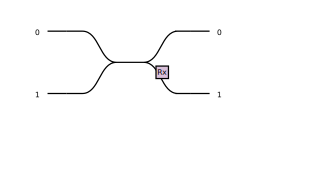

In [14]:
circuit_two_modes_balanced_bs = pcvl.Circuit(2)

circuit_two_modes_balanced_bs.add(0, BS())

pcvl.pdisplay(circuit_two_modes_balanced_bs)


In [15]:
p = pcvl.Processor("SLOS", circuit_two_modes_balanced_bs)
p.with_input(pcvl.BasicState([1,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
print(sample_count["results"])


{
  |1,0>: 495
  |0,1>: 505
}


Now we see we get roughly 50% of the state |1,0> which means 1 photon in the first mode and 0 and in the second mode, i.e. the photon took the upper path and 50% for the state |0,1> which means 0 photon in the first mode and 1 in the second mode, which means the photon took the bottom path.

Note that the Rx displayed on the figure is called the convention of the beam splitter.

Let's now consider a beam splitter with 10% chance to take the upper path and 90% to take the bottom path.

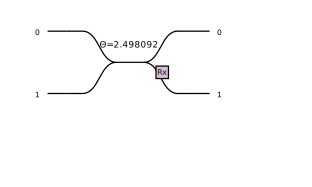

In [16]:
circuit_two_modes_biased_bs = pcvl.Circuit(2)

circuit_two_modes_biased_bs.add(0, BS(BS.r_to_theta(0.1)))

pcvl.pdisplay(circuit_two_modes_biased_bs)


In [24]:
p = pcvl.Processor("SLOS", circuit_two_modes_biased_bs)
p.with_input(pcvl.BasicState([1,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
print(sample_count["results"])

{
  |1,0>: 100
  |0,1>: 900
}


Now we see that the state |1,0> has probability 10% and state |0,1> has probability 90%.


But how can we use this to plot a Christmas tree ? Let's consider this 3 circuits and put the probability in a matrix. Each row in the matrix will corresponds to one circuit (the first row will be the two-mode circuits, the second with balanced beam splitter and the third with biased beam splitter) and each column will correspond to a spatial mode (the first column will correspond for the photon to be in the first spatial mode, i.e. the state |1,0> and the second column, to be in the second spatial mode, i.e. the state |0,1>). Here I will input the theoretical probabilities but in practice we will use the measured statistics with the simulation of the quantum chip.

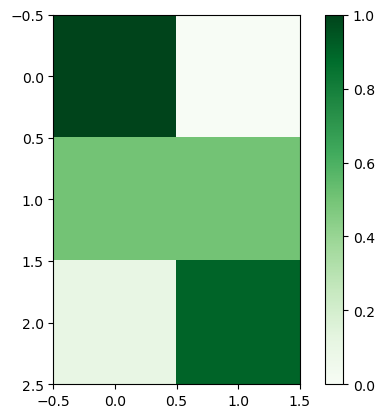

In [21]:
matrix = np.array([
    [1, 0],
    [0.5, 0.5],
    [0.1, 0.9]
])

plt.figure()
plt.imshow(
    matrix, cmap="Greens", interpolation="nearest"
)
plt.colorbar()

So we see that with very simple concepts, we are already able to plot some drawings. Now the goal will be to increase the number of spatial modes, and also to control what we draw.

## Drawing diagonal lines

What we want to do is to be able to draw diagonal lines, to plot cones. For that let's take an odd number of modes, let's say 11.

First let's define a small utility code that will analyze results to put them into the matrix. For each states at the output (i.e. for each possible recorded positions of the photon) it will put in the corresponding column the number of observations, for a given line.

In [30]:
def update_matrix(matrix, results, line):
    for k, v in results.items():
        for i, t in enumerate(k):
            if t:
                matrix[line][i] = v


matrix = np.zeros((11, 11))

In [31]:
circuit_diagonals = pcvl.Circuit(11)

For symmetry purposes, we will input the photon in the 5 spatial modes. Let's do our first line by just inputting this one and no optical components.

In [32]:
p = pcvl.Processor("SLOS", circuit_diagonals)
p.with_input(pcvl.BasicState([0,0,0,0,0,1,0,0,0,0,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
update_matrix(matrix, sample_count["results"], 0)
print(matrix)

[[   0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


Now let's add a beam splitter. We will take a balanced beam splitter, between mode 5 and 6. However this will not be very symmetrical as an output. We will tackle this issue with a permutation. Let's say we have three modes 0 1 and 2. The permutation [2, 1 , 0] will send the 0 mode to the 2 mode, the 1 mode to the 1 mode and the 2 mode to the 0 mode, effectively swapping 0 and 2. We can implement a swap between modes 4 and 5 so at the end our distribution is on modes 4 and 6 which is more symmetrical.


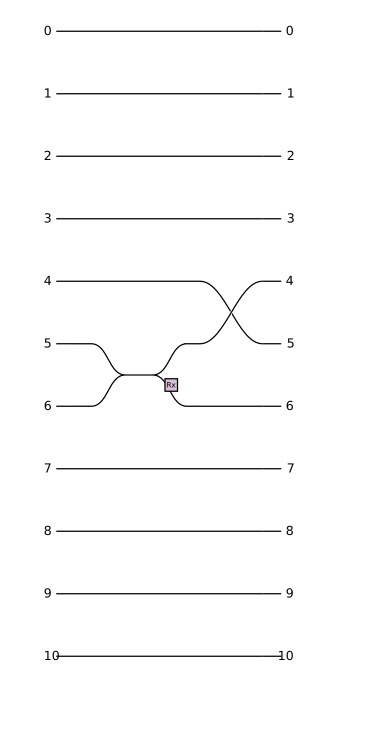

In [33]:
circuit_diagonals.add(5, BS())
circuit_diagonals.add(4, PERM([1,0]))

pcvl.pdisplay(circuit_diagonals)

In [34]:
p = pcvl.Processor("SLOS", circuit_diagonals)
p.with_input(pcvl.BasicState([0,0,0,0,0,1,0,0,0,0,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
update_matrix(matrix, sample_count["results"], 1)
print(matrix)

[[   0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  508.    0.  492.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


The tree starts to appear ! How can we continue the diagonal ? Starting back with the same circuit we can add a permutation between mode 3 and 4 and 6 and 7.


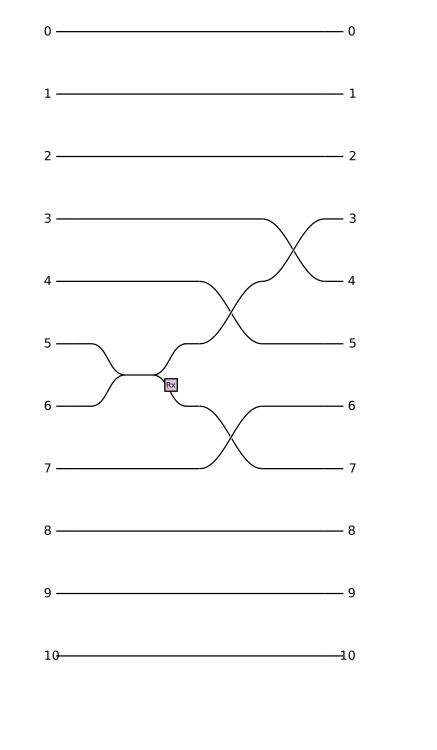

In [35]:
circuit_diagonals.add(3, PERM([1,0]))
circuit_diagonals.add(6, PERM([1,0]))
pcvl.pdisplay(circuit_diagonals)


In [36]:
p = pcvl.Processor("SLOS", circuit_diagonals)
p.with_input(pcvl.BasicState([0,0,0,0,0,1,0,0,0,0,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
update_matrix(matrix, sample_count["results"], 2)
print(matrix)

[[   0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  508.    0.  492.    0.    0.    0.    0.]
 [   0.    0.    0.  518.    0.    0.    0.  482.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


Nice ! We can continue this scheme to create diagonals. We will come back to it later, after we see how to create straight lines.

## Plotting straight lines

Before, we wanted to have only two possible modes as output. Now is a bit more tricky because we want to have more than 2 outputs. Using balanced beam splitter, and good arrangements we can have the power of two as number of output modes : 2, 4, 8, etc... but if we want to have any number we have to use biased beam splitters.

Let's say we want to have $n$ outputs, on the mode 0 to $n-1$. WHat we want is then to have each output with probability 1/n. We can use the first beam splitter on modes 0 and 1 with probability $\frac{1}{n}$ to go to 0 and $1-\frac{1}{n}$ to go to 1. Then we add a biased beam splitter on modes 1 and 2 but we need to update the probability p of going to the upper mode. Indeed, we want that $\left(1-\frac{1}{n}\right) \times p = \frac{1}{n}$ so that $p \neq \frac{1}{n}$ and $p = \frac{1}{n}\left(1-\frac{1}{n}\right)^{-1} = \frac{1}{n}\frac{n}{n-1} = \frac{1}{n-1}$. On we continue this scheme until we added n-1 beam splitters.

Let's do an example with $n=5$

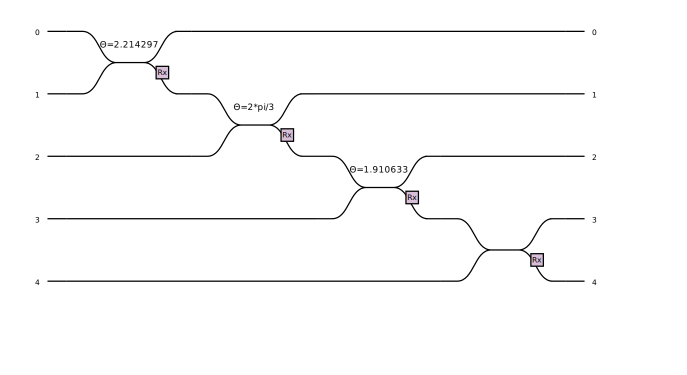

In [40]:
circuit_sl = pcvl.Circuit(5)

circuit_sl.add(0, BS(BS.r_to_theta(1/5)))
circuit_sl.add(1, BS(BS.r_to_theta(1/4)))
circuit_sl.add(2, BS(BS.r_to_theta(1/3)))
circuit_sl.add(3, BS(BS.r_to_theta(1/2)))

pcvl.pdisplay(circuit_sl)

In [42]:
p = pcvl.Processor("SLOS", circuit_sl)
p.with_input(pcvl.BasicState([1,0,0,0,0]))
sampler = pcvl.algorithm.Sampler(p)
sample_count = sampler.sample_count(1000)
print(sample_count["results"])

{
  |1,0,0,0,0>: 196
  |0,1,0,0,0>: 186
  |0,0,1,0,0>: 218
  |0,0,0,1,0>: 206
  |0,0,0,0,1>: 194
}


Note that we can generate straight lines with the length we want, we might want to have some symmetry and exclusion zone as depicted on the drawing below.


This can be done using the good permutation that is given by : 


## Drawing the Christmas tree

First let's define two functions, one to draw one line of the diagonals elements and one to draw the horizontal lines.

In [43]:
def sampling_level_symmetric(level: int):
    """Draw two points at m - level and m + level
    with probability 50%, 50%
    """
    circuit = pcvl.Circuit(2 * M + 1)
    if level > 0:
        circuit.add(M, BS())
        for i in range(0, level):
            circuit.add(M - i - 1, PERM([1, 0]))
            if i > 0:
                circuit.add(M + i, PERM([1, 0]))

    p = pcvl.Processor("SLOS", circuit)
    p.with_input(pcvl.BasicState([0] * M + [1] + [0] * M))
    sampler = pcvl.algorithm.Sampler(p)
    sample_count = sampler.sample_count(N)
    return sample_count["results"]

In [44]:
def sampling_level_line(l: int, excl: int):
    """Draw two lines, each of them of length l,
    exluced by a region of 2*excl-1 in the the center

    l=2
    excl=2
    m=5

    ###**###**###

    with probability 1/(2*l)
    """

    # First draw a line from spatial mode 0 to spatial mode 2*l
    L = 2 * l + (2 * excl - 1)
    offset = (2 * M + 1 - L) // 2

    circuit = pcvl.Circuit(2 * M + 1)
    for i in range(2 * l):
        circuit.add(i, BS(BS.r_to_theta(1 / (2 * l - i))))

    # Use a nice permutation to get the good result
    perm = (
        [offset + i for i in range(l)]
        + [offset + l + (2 * excl - 1) + i for i in range(l)]
        + [i for i in range(offset)]
        + [offset + l + i for i in range(2 * excl - 1)]
    )
    circuit.add(0, PERM(perm))

    p = pcvl.Processor("SLOS", circuit)
    p.with_input(pcvl.BasicState([1] + [0] * 2 * M))
    sampler = pcvl.algorithm.Sampler(p)
    sample_count = sampler.sample_count(N)
    return sample_count["results"]

Now let's define the number of modes with need, the numbers of sampling we are doing and the tree aesthetics.

In [45]:
# Circuit definitions

M = 25  # Number of modes : 2*m+1
N = 10000  # Number of samples

# Tree aesthetics

HEIGHT_FIRST_CONE = 15
WIDTH_FIRST_CONE = 5

HEIGHT_SECOND_CONE = 22
WIDTH_SECOND_CONE = 10

HEIGHT_THIRD_CONE = 26
WIDTH_THIRD_CONE = 4

WIDTH_BOTTOM = 6

HEIGHT_BOTTOM = 5

NUM_LINES = (
    HEIGHT_FIRST_CONE
    + HEIGHT_SECOND_CONE
    + HEIGHT_THIRD_CONE
    + HEIGHT_BOTTOM
    - WIDTH_FIRST_CONE
    - WIDTH_SECOND_CONE
    + 4
)

In [47]:
l = 0
matrix = np.zeros((NUM_LINES, 2 * M + 1))
for level in range(HEIGHT_FIRST_CONE):
    update_matrix(matrix, sampling_level_symmetric(level),l)
    l += 1

update_matrix(
    matrix,
    sampling_level_line(HEIGHT_FIRST_CONE - WIDTH_FIRST_CONE, WIDTH_FIRST_CONE),l
)
l += 1

for level in range(WIDTH_FIRST_CONE, HEIGHT_SECOND_CONE):
    update_matrix(matrix, sampling_level_symmetric(level),l)
    l += 1

update_matrix(
    matrix,
    sampling_level_line(HEIGHT_SECOND_CONE - WIDTH_SECOND_CONE, WIDTH_SECOND_CONE),l
)
l += 1

for level in range(WIDTH_SECOND_CONE, HEIGHT_THIRD_CONE):
    update_matrix(matrix, sampling_level_symmetric(level),l)
    l += 1

update_matrix(
    matrix, sampling_level_line(HEIGHT_THIRD_CONE - WIDTH_THIRD_CONE, WIDTH_THIRD_CONE),l
)
l += 1


for _ in range(HEIGHT_BOTTOM):
    update_matrix(matrix, sampling_level_symmetric(WIDTH_THIRD_CONE),l)
    l += 1

update_matrix(matrix, sampling_level_line(WIDTH_THIRD_CONE, 1),l)

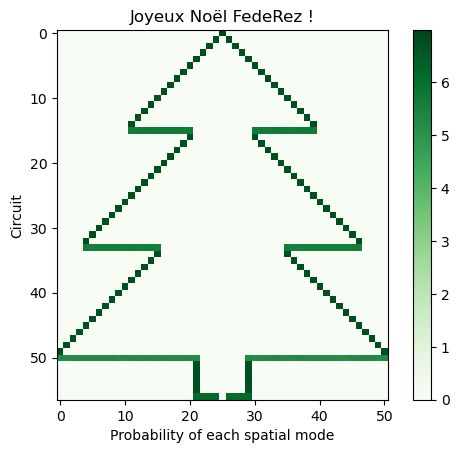

In [48]:
plt.figure()
plt.imshow(
    10 * np.log10(1 + np.log10(1 + matrix)), cmap="Greens", interpolation="nearest"
)
plt.xlabel("Probability of each spatial mode")
plt.ylabel("Circuit")
plt.title("Joyeux Noël FedeRez !")
plt.colorbar()
plt.show()


Et voilà !